# 3. Data Collection & Preprocessing

C:\Users\povhi\AppData\Local\Temp\ipykernel_24656\1838300750.py:17: DeprecationWarning: the argument `by` for `DataFrame.group_by_dynamic` is deprecated. It was renamed to `group_by` in version 0.20.14.
  comb_df_agg.group_by_dynamic(
C:\Users\povhi\AppData\Local\Temp\ipykernel_24656\1838300750.py:29: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  agg.pivot(index="date", columns="filter_type", values="count")


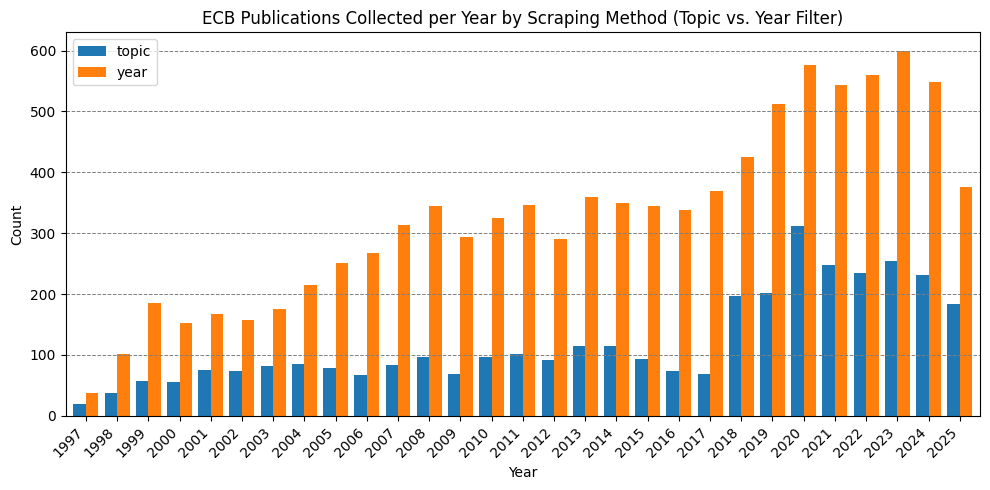

In [14]:
import polars as pl
import matplotlib.pyplot as plt
from collections import Counter

comb_df = pl.read_parquet(r"data\blogs_articles\combined_parsed_ecb_articles.parquet")
comb_df_agg = comb_df.group_by(['date', 'filter_type']).len()

# Ensure sorted (required for group_by_dynamic)
comb_df_agg = comb_df_agg.sort("date")

# Choose aggregation frequency
freq = "1y"   # can be "1w" or "1y"
start_by = "monday" if freq == "1w" else "window"

# Group by dynamic window + filter_type
agg = (
    comb_df_agg.group_by_dynamic(
            index_column="date",
            every=freq,
            closed="left",
            by="filter_type",
            start_by=start_by,
        )
      .agg(pl.col("len").sum().alias("count"))
      .sort(["date", "filter_type"]))

# Pivot wide so we can plot bars side-by-side
wide = (
    agg.pivot(index="date", columns="filter_type", values="count")
       .with_columns(pl.all().exclude("date").fill_null(0)))

# Convert to pandas for plotting
pdf = wide.to_pandas().set_index("date")

# Grouped barplot
ax = pdf.plot(kind="bar", figsize=(10, 5), width=0.8)
ax.set_title("ECB Publications Collected per Year by Scraping Method (Topic vs. Year Filter)")
ax.set_xlabel("Year")
ax.set_ylabel("Count")
plt.xticks(rotation=45, ha="right")

# Add horizontal gridlines
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')

# Change x-axis labels to integers (years)
labels = [d.year for d in pdf.index]
ax.set_xticklabels(labels)

plt.tight_layout()
plt.show()

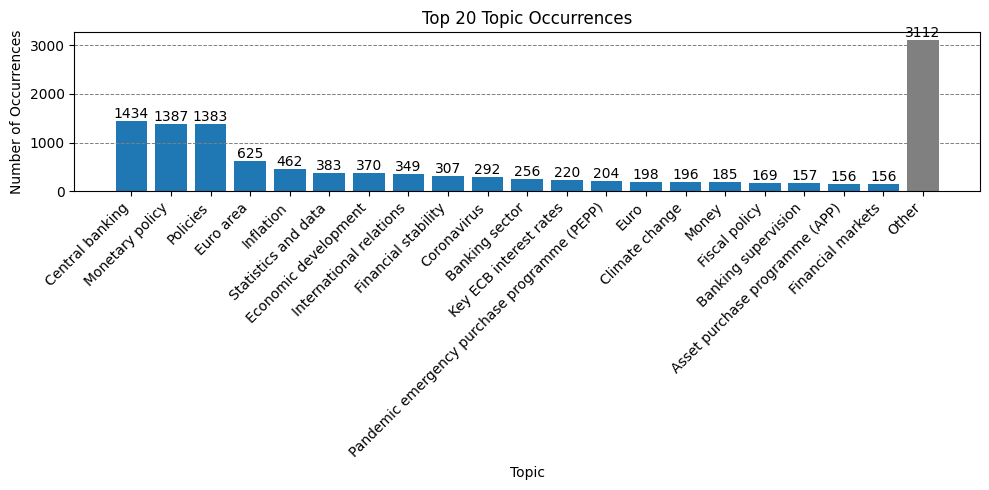

In [21]:
k = 20
topics = [x for z in comb_df.filter(pl.col('filter_type') == 'topic')['filter_value'].to_list() for x in z]
counts = Counter(topics)
most_common = counts.most_common(k)
other_count = sum(count for topic, count in counts.items() if topic not in dict(most_common))
plot_data = dict(most_common)
plot_data["Other"] = other_count

colors = ['grey' if topic == 'Other' else 'tab:blue' for topic in plot_data.keys()]

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.bar(plot_data.keys(), plot_data.values(), width=0.8, color=colors)
ax.set_title(f"Top {k} Topic Occurrences")
ax.set_xlabel("Topic")
ax.set_ylabel("Number of Occurrences")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, str(int(height)), 
            ha='center', va='bottom')
ax.yaxis.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.tight_layout()
plt.show()

# Results

In [ ]:
from pathlib import Path
from src.supervised_training import load_for_inference, predict
from tqdm import tqdm
from src.evaluation import compute_all_metrics
from src.utils import get_mapping

def markdown_rowwise_best(df_pl: pl.DataFrame, metric_col: str = "metric", minimize: list = None, precision: int = 3) -> str:
    """
    Create Markdown table where the best model per metric row is highlighted in green+bold,
    the second-best in blue+bold.
    """
    if minimize is None:
        minimize = ["hamming_loss"]

    pdf = df_pl.to_pandas()
    metrics = pdf[metric_col].tolist()
    models = [c for c in pdf.columns if c != metric_col]

    lines = []
    header = "| " + metric_col + " | " + " | ".join(models) + " |"
    sep = "|" + " --- |" * (len(models) + 1)
    lines.append(header)
    lines.append(sep)

    for i, m in enumerate(metrics):
        row_vals = pdf.loc[i, models].astype(float)
        # sort ascending if minimize, else descending
        sorted_vals = row_vals.sort_values(ascending=(m in minimize))
        best_val = sorted_vals.iloc[0]
        second_val = sorted_vals.iloc[1] if len(sorted_vals) > 1 else None

        cells = []
        for c in models:
            val = f"{row_vals[c]:.{precision}f}"
            if row_vals[c] == best_val:
                val = f"<span style='color:green;font-weight:bold'>{val}</span>"
            elif second_val is not None and row_vals[c] == second_val:
                val = f"<span style='color:blue;font-weight:bold'>{val}</span>"
            cells.append(val)
        line = "| " + str(m) + " | " + " | ".join(cells) + " |"
        lines.append(line)

    return "\n".join(lines)

DATA_DIR = Path('data/blogs_articles')
MODEL_DIR = Path('models')
test_df = pl.read_parquet(DATA_DIR / "test_topics.parquet")
test_df = test_df.sort(by='id')

# fine tuned roberta eval
ft_path = Path(r'models\experiment_202509050949') / 'supervise_finetune_model_202509050949_baseline'
preds = predict(test_df['text'].to_list(), ft_path, 'cuda', use_chunking=True, agg = 'max')
test_pred = pl.DataFrame(preds).with_columns(pl.Series("id", test_df['id'].to_list()))
test_df_pred = test_df.join(test_pred, on = 'id', how ='left')
ft_all_metrics = compute_all_metrics(test_df_pred['topic_label'].to_list(), test_df_pred['predicted_labels'].to_list(), get_mapping(id_to_label=True))
ft_per_label_table = pl.DataFrame(ft_all_metrics.pop('per_label_table'))
ft_all_metrics_df = pl.DataFrame({
    "metric": list(ft_all_metrics.keys()),
    "finetuned-xlm_roberta_base": list(ft_all_metrics.values())}, 
    strict = False)

# Only Test
usv_metrics = pl.read_csv(MODEL_DIR / 'topic_model_all_metrics_per_model_test.csv')
usv_metrics = usv_metrics.rename({x:f'usv-{x}' for x in usv_metrics.columns if x != 'metric'})
cb_metrics = pl.read_csv(MODEL_DIR / 'cat_boost_models/all_metrics_per_model.csv')
cb_metrics = cb_metrics.rename({x:f'cb-{x}' for x in cb_metrics.columns if x != 'metric'})


all_metrics = usv_metrics.join(cb_metrics, on='metric', how = 'left').join(ft_all_metrics_df, on = 'metric', how = 'left')
all_metrics.write_csv(MODEL_DIR / 'all_metrics_all_models.csv')

md_table = markdown_rowwise_best(all_metrics, metric_col="metric", minimize=["hamming_loss"], precision=3)
print(md_table)